# Choosing the right number of clusters
In some, but not all clustering methods, we will need to specify how many clusters we expect to find in the data. Since our approach is unsupervised, it is very likely we don't necessary have a good estimate of what the real number of clusters should be for our data. So how do we determine, based on the output of our cluster algorithms, the number of clusters the data contains? Turns out there is an objective measure ofperformance we can use for this. After K-means has converged for a particular combination of user-defined n number of clusters and initial random starting values for the means of these n clusters, we can compute what is known as the cost. Perhaps somewhat similar to the cost functions we used in earlier chapter to perform linear and logistic regression and classification, cost in clustering (K-means for now) capture the difference between our solution after convergence and how well, in theory, we could have done. In supervised learning, like regression and classification, we can use the actual outcomes in our training data to compute this cost. In clustering, where we have no such outcome data available, we can nevertheless still define an objective optimal solution. 

In clustering we compute cost as the squared distance between all the points to their closest cluster center. To see why this yields a metric that is useful as a measure of performance, in the absence of having any ground truth outcome data about the actual labels, let us consider a few edge cases. 

### Import

In [5]:
import os
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import spectral.io.aviris as aviris
import colour
from PIL import Image
from scipy.stats import multivariate_normal as mnorm
from scipy import ndimage
from matplotlib import cm
from matplotlib.colors import LogNorm
from mpl_toolkits import mplot3d
from skimage import io, color
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist
from scipy.spatial.distance import squareform
from sklearn import datasets
from colour.plotting import *
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import silhouette_score

### Fonts

In [6]:
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Helvetica'}

### Cost Helper Function

In [7]:
def compute_cost(X,clusters):
    
    #Init
    cost = 0

    #Compute the distance between each point and the two clusters
    D = cdist(X,clusters)
    Dmin = np.min(D,axis=1)
    labels = np.argmin(D,axis=1)
    
    #compute cost as the sum of the squared distance between each point and its nearest cluster
    cost = np.sum(Dmin**2)
    
    #Return
    return cost,labels

### Parameters

In [8]:
resolution = 5
no_points = 200

### Chaos to perfection
For cost to be relevant, we will have to look at relative difference between the compute cost between different scenarios. Imagine first that we start off with a set of points for which half are extremely close to one or the two clusters we defined, and the other half very close to the other. We can compute the cost in that scenario, and compute to the cost we obtain when we start moving the points outward and away from their respective cluster centrpoids. In this case, we can compare computed costs, since all other things are held equal. 

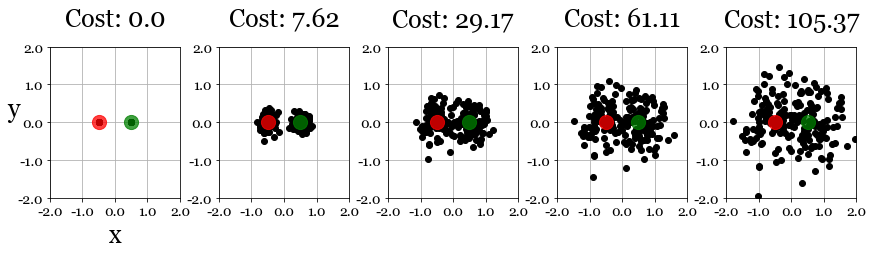

In [11]:
clusters = np.array([[-0.5,0],[0.5,0]])
Xbase = np.random.normal(0,1,(no_points,2))
labels = np.random.randint(0,2,no_points)
idx0 = np.where(labels == 0)[0]
idx1 = np.where(labels == 1)[0]

plt.figure(figsize=(14,3))
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.8, wspace=0.3, hspace=0.3)
for i in range(5):
    multiplier = i/5 * 0.666
    X = Xbase.copy()
    X[idx0,0] = (Xbase[idx0,0]*multiplier) + clusters[0,0]
    X[idx0,1] = (Xbase[idx0,1]*multiplier) + clusters[0,1]
    X[idx1,0] = (Xbase[idx1,0]*multiplier) + clusters[1,0]
    X[idx1,1] = (Xbase[idx1,1]*multiplier) + clusters[1,1]
    cost,labels = compute_cost(X,clusters)

    plt.subplot(1,5,i+1)
    plt.scatter(X[idx0,0],X[idx0,1],edgecolor=(0,0,0),facecolor=(0,0,0),alpha=1.0,zorder=100)
    plt.scatter(X[idx1,0],X[idx1,1],edgecolor=(0,0,0),facecolor=(0,0,0),alpha=1.0,zorder=100)
    plt.scatter(clusters[0,0],clusters[0,1],c='r',s=200,alpha=0.75,zorder=200)
    plt.scatter(clusters[1,0],clusters[1,1],c='g',s=200,alpha=0.75,zorder=200)
    if (i == 0):
        plt.xlabel('x',fontsize=25,**csfont);
        plt.ylabel('y',fontsize=25,**csfont,rotation=0);
    plt.yticks(np.linspace(-2,2,resolution),labels=np.linspace(-2,2,resolution),fontsize=14,**csfont);
    plt.xticks(np.linspace(-2,2,resolution),labels=np.linspace(-2,2,resolution),fontsize=14,**csfont);
    plt.grid();
    plt.axis((-2,2,-2,2));
    plt.title('Cost: ' + str(np.round(cost,2)),fontsize=25,**csfont,pad=20);
plt.savefig('../../assets/figures/017/hockey_stick_cost_closeness.png',dpi=300,bbox_inches="tight")

### Colors for different categories

In [20]:
val = np.linspace(0,2*np.pi,361)[:-1]
val = val + 1
x = np.sin(val)
y = np.cos(val)
lab = np.zeros((360,3))
lab[:,0] = 70
lab[:,1] = 70*x
lab[:,2] = 70*y
category_colors = color.lab2rgb(lab)

### The cost associated with different number of clusters
The above figure shows a steady increae in cost as our clusters become less defined and points spread out outward from the centroid repreenting the cluster. It also shows the theoretical zero cost, where all points are equal to either centroid, something we do not expect to happen for real data, and something that wouldn't necessarily be all that informative if it did. But as luck would have it, the same relationship we observe between cost and clustering is found for instances where do not vary the distance between points and the centroids, but also when ve vary the number of clusters we specify as an input to our K-means clustering algorithm. In addition, plotting the cost as a function of the number we specifiy K-means needs to detect can help us determine what the optimal number of clusters actually is. We will use the scikit-learn make_blobs tool to generate data with n number of clusters to serve as synthetic input data to our K-means algorithm. 

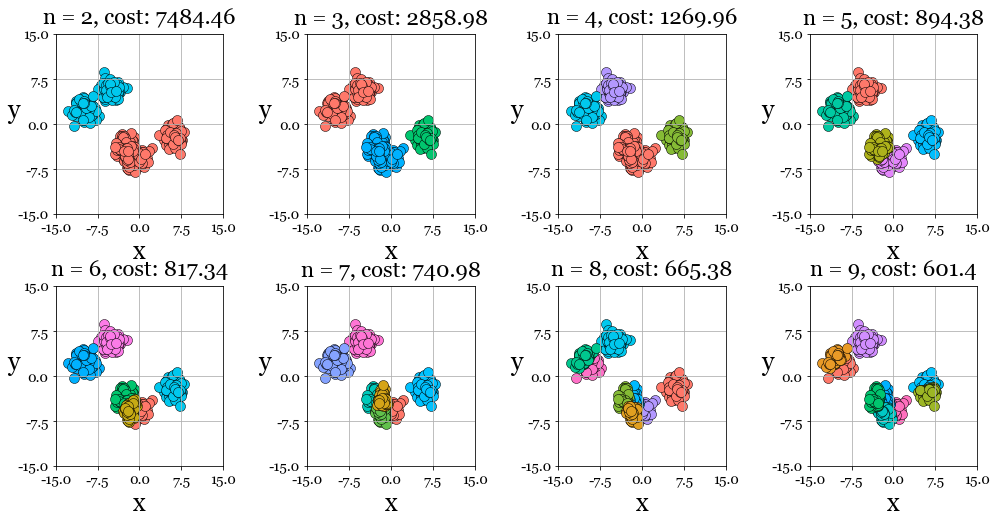

In [31]:
n_samples = 500
n_real_clusters = 5
random_state = 300
X,y = datasets.make_blobs(n_samples=n_samples, n_features=2, centers = n_real_clusters, random_state=random_state)
costs = []
plt.figure(figsize=(16,6))
plt.subplots_adjust(left=0.1,bottom=0.0, right=0.9, top=1.0, wspace=0.5, hspace=0.4)
for n in range(2,10):
    plt.subplot(2,4,n-1)
    kmeans = KMeans(n_clusters=n, random_state=random_state).fit(X)
    ypred = kmeans.predict(X)
    cost,labels = compute_cost(X,kmeans.cluster_centers_)
    costs.append(cost)
    for i in range(n):
        color_index = int(360 / n * i)
        idx = np.where(ypred == i)[0]
        plt.scatter(X[idx,0],X[idx,1],s=100,alpha=1.0,edgecolor='k',linewidth=0.5,
                    facecolor=category_colors[color_index,:])
    plt.grid('on');
    plt.xlabel('x',fontsize=25,**csfont);
    plt.ylabel('y',fontsize=25,**csfont,rotation=0);
    plt.yticks(np.linspace(-15,15,resolution),labels=np.linspace(-15,15,resolution),fontsize=14,**csfont);
    plt.xticks(np.linspace(-15,15,resolution),labels=np.linspace(-15,15,resolution),fontsize=14,**csfont);
    plt.axis((-15,15,-15,15));
    plt.title('n = ' + str(n) + ', cost: ' + str(np.round(cost,2)),fontsize=22,**csfont,pad=10);
plt.savefig('../../assets/figures/017/hockey_stick_varying_no_clusters.png',dpi=300,bbox_inches="tight")

### The Hockey Stick Curve
When we plot cost as a function of number of clusters we specifiy K-means to detect on our behalf, hopefully you will notice the inflection point precisly at the number of clusters actually present in our synthetic data. Because of its shape, it is ususally referred to as the hockey stick curve. Why specifically this curve? When we specify too few clusters, points belonging to clusters seperated substantially will be lumped together. This creates a relatively large asosciated cost. This will rapidly drop until the correct number of clusters is specified. Should we increase the number of to be detected clusters further after that, we are now unneccassrily dividing clusters into smaller clusters. This will artifically reduce the cost, as points will continue to be closer to their cluster centroids. However, since the points were already close in space before, the cost will drop at a much slower pace, creating the inflection point in the graph below. At the extreme, each point is its own cluster, in which case the cost will be zero, but the cost at clusters consisting of only two points already has an extremely low cost associated with it. Depending on the actual amount of clustering in your data, irrespective of the number of clusters your data contains, this curve can be more or less pronounced, and usually some visual inspection will give you an idea of whether you are on the right track. 

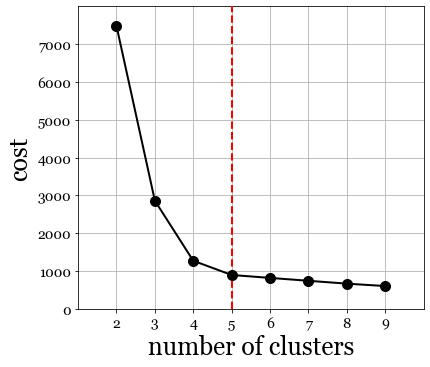

In [29]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.8, wspace=0.1, hspace=0.1)
plt.plot(range(2,10),costs,'k',linewidth=2)
plt.grid('on');
plt.ylabel('cost',fontsize=25,**csfont);
plt.plot([5,5],[0,8000],c=(1,0,0),linewidth=2,linestyle='--',zorder=10)
plt.xlabel('number of clusters',fontsize=25,**csfont,rotation=0);
plt.scatter(range(2,10),costs,c='k',s=100,zorder=10)
plt.xticks(range(2,10),labels=range(2,10),fontsize=14,**csfont);
plt.yticks(range(0,8000,1000),labels=range(0,8000,1000),fontsize=14,**csfont);
plt.axis((1,10,0,8000))
plt.savefig('../../assets/figures/017/hockey_stick_varying_no_clusters_curve.png',dpi=300,bbox_inches="tight")


### Other Algorithms
Is this metric unique to K-means? Let us try the same approach, but with a Gaussian Mixture Model

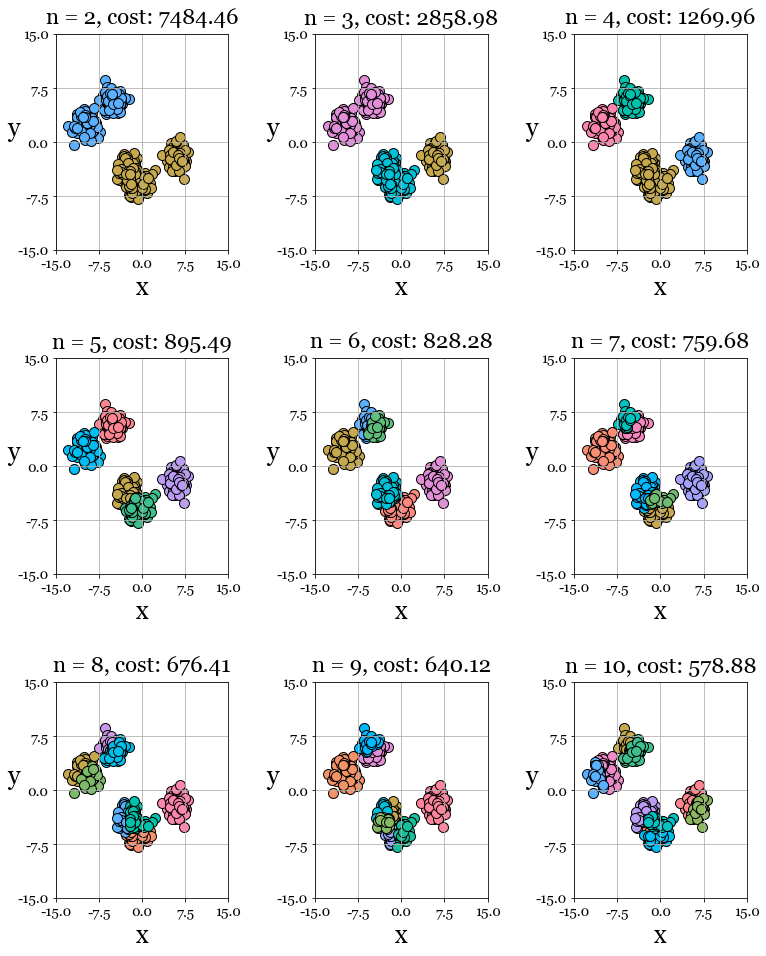

In [60]:
n_samples = 500
n_real_clusters = 5
random_state = 300
X,y = datasets.make_blobs(n_samples=n_samples, n_features=2, centers = n_real_clusters, random_state=random_state)
costs = []
plt.figure(figsize=(12,12))
plt.subplots_adjust(left=0.1,bottom=0.0, right=0.9, top=1.0, wspace=0.5, hspace=0.5)
for n in range(2,11):
    plt.subplot(3,3,n-1)
    gmm = GaussianMixture(n_components=n, covariance_type="full")
    gmm.fit(X)
    ypred = gmm.predict(X)
    cost,labels = compute_cost(X,gmm.means_)

    costs.append(cost)
    for i in range(n):
        color_index = int(360 / n * i)
        idx = np.where(ypred == i)[0]
        plt.scatter(X[idx,0],X[idx,1],s=100,alpha=1.0,edgecolor='k',
                    facecolor=category_colors[color_index,:])
    plt.grid('on');
    plt.xlabel('x',fontsize=25,**csfont);
    plt.ylabel('y',fontsize=25,**csfont,rotation=0);
    plt.yticks(np.linspace(-15,15,resolution),labels=np.linspace(-15,15,resolution),fontsize=14,**csfont);
    plt.xticks(np.linspace(-15,15,resolution),labels=np.linspace(-15,15,resolution),fontsize=14,**csfont);
    plt.axis((-15,15,-15,15));
    plt.title('n = ' + str(n) + ', cost: ' + str(np.round(cost,2)),fontsize=22,**csfont,pad=10);
plt.savefig('../../assets/figures/017/hockey_stick_varying_no_clusters_ggm.png',dpi=300,bbox_inches="tight")

### The Hockey Stick Curve for GMM

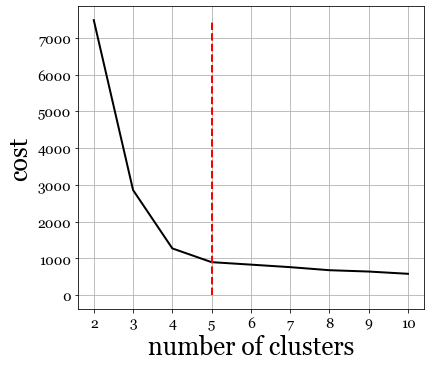

In [61]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.8, wspace=0.1, hspace=0.1)
plt.plot(range(2,11),costs,'k',linewidth=2)
plt.grid('on');
plt.ylabel('cost',fontsize=25,**csfont);
plt.plot([5,5],[0,max(costs)],c=(1,0,0),linewidth=2,linestyle='--')
plt.xlabel('number of clusters',fontsize=25,**csfont,rotation=0);
plt.xticks(range(2,11),labels=range(2,11),fontsize=14,**csfont);
plt.yticks(range(0,8000,1000),labels=range(0,8000,1000),fontsize=14,**csfont);
plt.savefig('../../assets/figures/017/hockey_stick_varying_no_clusters_curve_gmm.png',dpi=300,bbox_inches="tight")